<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment2/workbook-A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [ ]:
# Install PyTorch Geometric
# !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q to·rch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q torch-geometric

In [2]:
import torch
import requests
import io
import pickle
import json

def download(url, filetype='tensor'):
    if filetype not in ['tensor', 'pickle', 'json']:
        raise ValueError('Incorrect filetype')
    response = requests.get(url)
    response.raise_for_status()
    if filetype == 'tensor':
        return torch.load(io.BytesIO(response.content))
    elif filetype == 'pickle':
        return pickle.load(io.BytesIO(response.content))
    elif filetype == 'json':
        return json.load(io.BytesIO(response.content))

# Task 1

In [3]:
## Download the dataset for image retrieval ##
data_1 = download('https://surfdrive.surf.nl/files/index.php/s/EH2tN7JiZnwdIXg/download', filetype='tensor')
data_metadata = download('https://github.com/pmernyei/wiki-cs-dataset/raw/master/dataset/metadata.json', filetype='json')

In [4]:
num_node = data_1.x.shape[0]
num_edge = data_1.edge_index.shape[1]
num_node_feature = data_1.x.shape[1]
num_class = int(max(data_1.y)+1)
num_label = sum(data_1.train_mask)

print(f'Num nodes: {num_node}')
print(f'Num edges: {num_edge}')
print()
print(f'Num node features: {num_node_feature}')
print(f'Num classes: {num_class}')
print()
print(f'Num training labels: {num_label}')

Num nodes: 10701
Num edges: 251927

Num node features: 300
Num classes: 10

Num training labels: 522


In [5]:
for i in range(num_class):
    print('{}: {}'.format(i, data_metadata['labels'][str(i)]))

0: Computational linguistics
1: Databases
2: Operating systems
3: Computer architecture
4: Computer security
5: Internet protocols
6: Computer file systems
7: Distributed computing architecture
8: Web technology
9: Programming language topics


In [6]:
def print_node(idx, url=True, label=True):
    node_info = data_metadata['nodes'][idx]
    print(f'--Node {idx}--')
    if url:
        title = node_info['title']
        wiki_url = 'https://en.wikipedia.org/wiki/' + title
        print(wiki_url)
    if label:
        print('Label:', node_info['label'])
    print()

In [7]:
for i in range(10):
    print_node(i)

--Node 0--
https://en.wikipedia.org/wiki/Twilio
Label: Distributed computing architecture

--Node 1--
https://en.wikipedia.org/wiki/Program_compatibility_date_range
Label: Operating systems

--Node 2--
https://en.wikipedia.org/wiki/SYSTAT_(DEC)
Label: Operating systems

--Node 3--
https://en.wikipedia.org/wiki/List_of_column-oriented_DBMSes
Label: Databases

--Node 4--
https://en.wikipedia.org/wiki/Stealth_wallpaper
Label: Computer security

--Node 5--
https://en.wikipedia.org/wiki/Scalable_TCP
Label: Internet protocols

--Node 6--
https://en.wikipedia.org/wiki/Carrier_IQ
Label: Computer security

--Node 7--
https://en.wikipedia.org/wiki/ACF2
Label: Operating systems

--Node 8--
https://en.wikipedia.org/wiki/Dorkbot_(malware)
Label: Computer security

--Node 9--
https://en.wikipedia.org/wiki/Lout_(software)
Label: Programming language topics



In [12]:
## Build the article retrieval system ##
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from tqdm import tqdm
import matplotlib.pyplot as plt

In [95]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels)  # the node's word vector (with size num_features) is
                                                              # transformed to a vector of size hidden_channels
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

        self.conv3 = SAGEConv(hidden_channels, num_classes)  # we convert our nodes from hidden_channels to num_classes, the
                                                             # last update step turns a node's state into a node-class prediction

    def forward(self, x, edge_index):
        # x = (1), all nodes contain information about itself (x_size, num_features)
        x = self.conv1(x, edge_index) # x = (2), update all nodes for the first time, returning (x_size, hidden_channels)
        x = x.relu()  # activation function
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5)  # attempt to combat overfitting, as we only have few labels
        x = self.conv3(x, edge_index)  # x = (3), update all nodes again, returning (x_size, num_classes)
                                       # this final update transforms each node embedding to a class prediction
                                       # we do not apply an activation, as the PyTorch CCE calculation
                                       # takes care of treating this output as 'softmax'.
        return x

In [92]:
class GNNTrainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 epochs: int,
                 data
                 ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.epochs = epochs
        self.data = data

    def run_trainer(self):
        losses = []
        train_accs = []
        val_accs = []
        x = self.data.x.to(self.device)
        edge_index = self.data.edge_index.to(self.device)
        y = self.data.y.to(self.device)
        for epoch in tqdm(range(self.epochs)):
            self.model.train()  # train mode
            self.optimizer.zero_grad()
            out = self.model(x, edge_index)
            loss = self.criterion(out[self.data.train_mask], y[self.data.train_mask])
            loss.backward()
            self.optimizer.step()

            self.model.eval()
            pred = out.argmax(dim=1)
            train_correct = pred[self.data.train_mask] == y[self.data.train_mask]
            train_acc = int(train_correct.sum()) / int(self.data.train_mask.sum())
            val_correct = pred[self.data.test_mask] == y[self.data.test_mask]
            val_acc = int(val_correct.sum()) / int(self.data.test_mask.sum())
            losses.append(loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            if epoch % 20 == 0:
                print('Epoch: {}, Loss: {}, ACC_train: {}, ACC_val: {}'.format(epoch, loss, train_acc, val_acc))
        fig, axs = plt.subplots(2, 1, figsize=(8, 10))
        t = range(1, self.epochs + 1)
        axs[0].plot(t, losses, label = 'Training Loss')
        axs[0].set_xlabel('epoch')
        axs[0].set_ylabel('loss')
        axs[0].grid(True)
        axs[0].legend()

        axs[1].plot(t, train_accs, label = 'Training Accuracy')
        axs[1].plot(t, val_accs, label = 'Validation Accuracy')
        axs[1].set_xlabel('epoch')
        axs[1].set_ylabel('accuracy')
        axs[1].grid(True)
        axs[1].legend()

        plt.show()

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(hidden_channels=32, num_features=num_node_feature, num_classes=num_class).to(device=device)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
trainer = GNNTrainer(model=model,
                     device=device,
                     criterion=loss_func,
                     optimizer=optimizer,
                     epochs=200,
                     data=data_1)

  6%|▌         | 12/200 [00:00<00:03, 59.29it/s]

Epoch: 0, Loss: 2.3434641361236572, ACC_train: 0.1053639846743295, ACC_val: 0.08358264771877337


 18%|█▊        | 35/200 [00:00<00:02, 70.02it/s]

Epoch: 20, Loss: 1.1472718715667725, ACC_train: 0.6149425287356322, ACC_val: 0.6035901271503366


 26%|██▌       | 51/200 [00:00<00:02, 72.73it/s]

Epoch: 40, Loss: 0.6898232102394104, ACC_train: 0.7701149425287356, ACC_val: 0.6697830964846672


 38%|███▊      | 75/200 [00:01<00:01, 75.42it/s]

Epoch: 60, Loss: 0.4130113124847412, ACC_train: 0.8601532567049809, ACC_val: 0.6985789080029918


 46%|████▌     | 91/200 [00:01<00:01, 74.92it/s]

Epoch: 80, Loss: 0.23578552901744843, ACC_train: 0.9157088122605364, ACC_val: 0.7094240837696335


 54%|█████▎    | 107/200 [00:01<00:01, 74.77it/s]

Epoch: 100, Loss: 0.19677188992500305, ACC_train: 0.9252873563218391, ACC_val: 0.7170905011219147


 66%|██████▌   | 131/200 [00:01<00:00, 74.61it/s]

Epoch: 120, Loss: 0.12364403158426285, ACC_train: 0.9578544061302682, ACC_val: 0.7144727000747944


 78%|███████▊  | 155/200 [00:02<00:00, 74.75it/s]

Epoch: 140, Loss: 0.10069931298494339, ACC_train: 0.9693486590038314, ACC_val: 0.7204562453253552


 86%|████████▌ | 171/200 [00:02<00:00, 74.75it/s]

Epoch: 160, Loss: 0.06793355941772461, ACC_train: 0.9731800766283525, ACC_val: 0.7208302169035153


 98%|█████████▊| 195/200 [00:02<00:00, 74.71it/s]

Epoch: 180, Loss: 0.05536836013197899, ACC_train: 0.9789272030651341, ACC_val: 0.7208302169035153


100%|██████████| 200/200 [00:02<00:00, 73.38it/s]


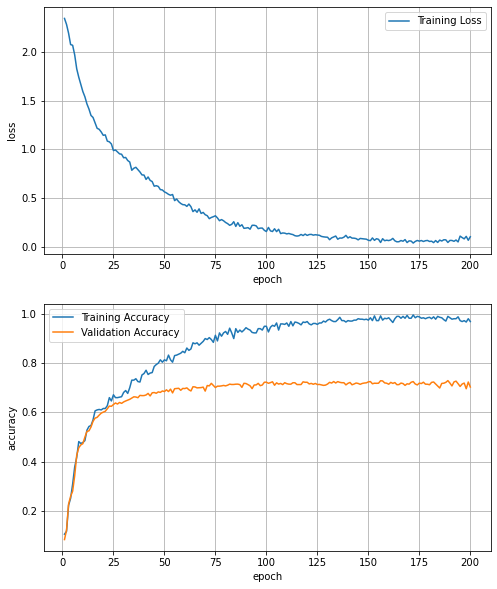

In [97]:
trainer.run_trainer()

In [8]:
## Evaluate the article retrieval system ##


Data(edge_index=[2, 251927], test_mask=[10701], train_mask=[10701], x=[10701, 300], y=[10701])

# Task 2

In [9]:
## Build the anomaly detection model ##

In [10]:
## Download the anomaly evaluation data ##
data_2 = download('https://surfdrive.surf.nl/files/index.php/s/EzMkh3SZbsbJb2i/download', filetype='tensor')
is_anomaly = download('https://surfdrive.surf.nl/files/index.php/s/wrK5xipcIC9DHhu/download', filetype='pickle')

In [11]:
total_node = data_2.x.shape[0]
total_edge = data_2.edge_index.shape[1]
new_node = total_node - num_node
new_edge = total_edge - num_edge
print(f'Num new nodes: {new_node}')
print(f'Num new edges: {new_edge}')

Num new nodes: 2000
Num new edges: 50176


In [12]:
print(f'Indices of new nodes are {num_node}...{total_node-1}')
print('The first 1000 are real articles, the last 1000 are anomaly articles')
print('You can use the map "is_anomaly" to identify whether a node is an anomaly or not')
e_real = num_node+500
e_anomaly = num_node+1500
print(f'E.g., is_anomaly[{e_real}] = {is_anomaly[e_real]} and is_anomaly[{e_anomaly}] = {is_anomaly[e_anomaly]}')

Indices of new nodes are 10701...12700
The first 1000 are real articles, the last 1000 are anomaly articles
You can use the map "is_anomaly" to identify whether a node is an anomaly or not
E.g., is_anomaly[11201] = 0 and is_anomaly[12201] = 1


In [ ]:
## Evaluate the anomaly detection model ##